In [372]:
import OpenEphys as OE
import numpy as np
import matplotlib.pyplot as plt

Loading data and separating channel of interest

In [354]:
data = OE.load('all_channels.events')
Fs = 30000;
aux = data['channel'];
a = np.where(aux == 1.0); #similar to function find in matlab, finding where there was nose poke

loading events...


Next we need to separate only the nosepoke periods higher than 50 ms

In [355]:
#### Extracting trial periods #####
timestamps = data['timestamps'];
timestamps = timestamps[a];
if ( (np.size(timestamps)%2) == 1):
    auxNP = 1;
else:
    auxNP = 0;
NPstart = timestamps[np.arange(0,np.size(timestamps)-auxNP,2)];
NPend = timestamps[np.arange(1,np.size(timestamps)-auxNP,2)];
DRRDtime = (NPend-NPstart)/Fs;
aux = np.where(DRRDtime >= .05);
DRRDtime = DRRDtime[aux];
NPstart = NPstart[aux]
NPend = NPend[aux]

Creating figure to analyze

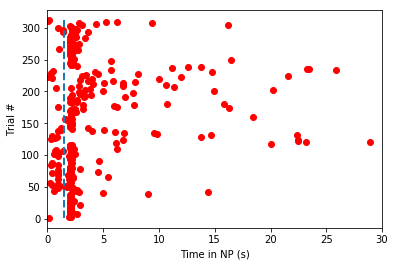

In [384]:
#figure
fig,ax = plt.subplots()
ax.set_xlim([0, 30])
ax.set_xlabel('Time in NP (s)')
ax.set_ylabel('Trial #')
x = DRRDtime;
y = np.arange(np.size(DRRDtime))+1;
plt.plot(x,y,'ro')
line1, = ax.plot(np.ones(np.size(DRRDtime))*1.5 ,y,'--', linewidth=2,label='Dashes set retroactively')
plt.show()

Now, we are going to implement Reyes method to detect change points, base on sequential t-test

In [404]:
#implementing Reyes method of change-point detection
from scipy import stats

windSize = 20;
Odds = np.zeros(np.size(DRRDtime)-2*windSize)
Avg = np.zeros(np.size(DRRDtime)-windSize)
np.random.seed(12345678)
for idx in range(windSize,np.size(DRRDtime)-2*windSize):
    auxODD = stats.ttest_ind(DRRDtime[range(idx-windSize+1,idx+1)],DRRDtime[range(idx+1,idx+windSize+1)])
    Odds[idx-20] = (1 - auxODD[1])/auxODD[1]  #(1-p)/p
for idx in range(windSize,np.size(DRRDtime)):
    auxAVG = np.mean(DRRDtime[idx-windSize:idx])
    Avg[idx-20] = auxAVG


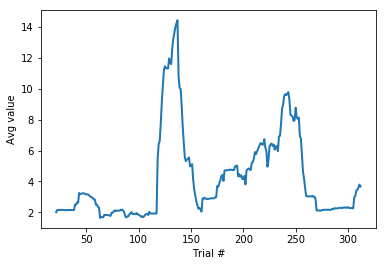

In [405]:
fig,ax = plt.subplots()
#ax.set_xlim([0, 5])
ax.set_xlabel('Trial #')
ax.set_ylabel('Avg value')
x = np.arange(np.size(Avg));
y = Avg;
line1, = ax.plot(x+21 ,y,'-', linewidth=2)
plt.show()

Plotting Odds

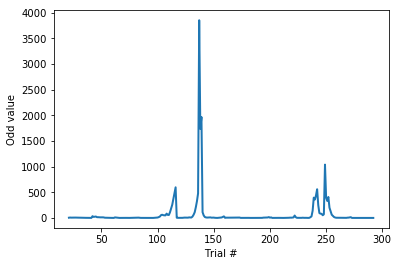

In [397]:
#
fig,ax = plt.subplots()
#ax.set_xlim([0, 5])
ax.set_xlabel('Trial #')
ax.set_ylabel('Odd value')
x = np.arange(np.size(Odds));
y = Odds;
line1, = ax.plot(x+21 ,y,'-', linewidth=2)
plt.show()

Better figure to present, sharing y-axis

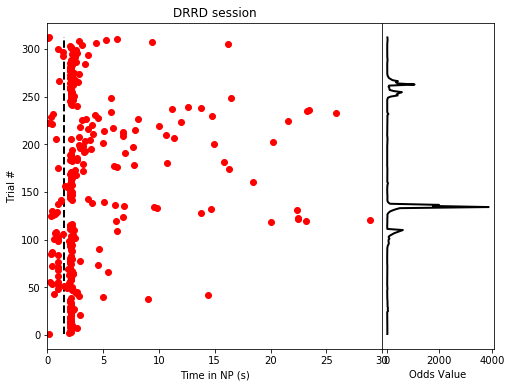

In [386]:
from matplotlib import gridspec

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax1 = plt.subplot(gs[0])
ax1.set_title('DRRD session')
ax1.set_xlim([0, 30])
ax1.set_xlabel('Time in NP (s)')
ax1.set_ylabel('Trial #')
x = DRRDtime;
y = np.arange(np.size(DRRDtime))+1;
line1 = ax1.plot(np.ones(np.size(DRRDtime))*1.5 ,y,'--', linewidth=2,color = 'k')
ax1.plot(x,y,'ro')

ax2 = plt.subplot(gs[1])
ax2.set_xlabel('Odds Value')
y = np.arange(np.size(Odds));
x = Odds;
line1, = ax2.plot(x+21 ,y,'-', linewidth=2,color = 'k')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
ax2.set_yticks([])
fig.subplots_adjust(wspace=0)

plt.show()

In order to select the 'true' and whether there is a change-point or not, a bootstrap need to be done. As below:

In [392]:
#bootstrap
import random as rnd

BSval = np.zeros(10000)
for ind in range(0,10000):
    auxBS = rnd.sample(DRRDtime,np.size(DRRDtime))
    
    windSize = 20;
    BSOdds = np.zeros(np.size(auxBS)-2*windSize)
    np.random.seed(12345678)
    for idx in range(windSize,np.size(auxBS)-2*windSize):
        auxODD = stats.ttest_ind(auxBS[idx-windSize:idx],auxBS[idx:idx+windSize])
        BSOdds[idx-20] = (1 - auxODD[1])/auxODD[1]  #(1-p)/p
    BSval[ind] = np.amax(BSOdds)

Observing the distribution and where the true change points stops

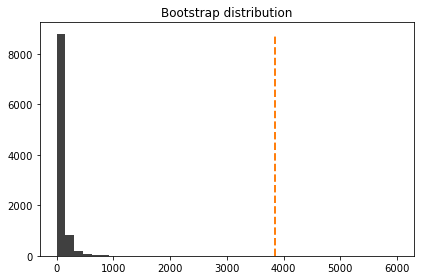

In [406]:
fig,ax = plt.subplots()
bins = np.linspace(0,6000,40)
out = ax.hist(BSval,bins, normed=0, histtype='bar', facecolor='k', alpha=0.75)
y = np.linspace(0,np.amax(out[0]),10)
line1, = ax.plot(np.ones(np.size(y))*np.amax(Odds) ,y,'--', linewidth=2,label='Dashes set retroactively')
ax.set_title('Bootstrap distribution')
fig.tight_layout()
plt.show()

In [408]:
bin_edges = out[1]
nhist = np.cumsum(np.float32(out[0])/np.float32(10000))

auxHist = np.where(bin_edges >= np.amax(Odds))
#auxHist[0]-1
auxHist = nhist[auxHist[0]-1]
#nhist[auxHist[0]]
pValue = 1-auxHist[0]
pValue
print "P-value at max peak = %f32" % pValue

P-value at max peak = 0.00040032


Let's plot the response histogram from before and after the max peak

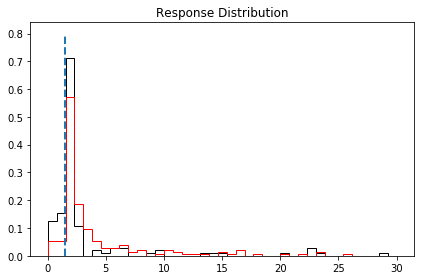

In [413]:
auxCP = np.arange(np.size(Odds))
auxTrial = np.where(Odds == np.amax(Odds))
Trial = auxCP[auxTrial]+21
fig,ax = plt.subplots()
bins = np.linspace(0,30,40)
ax.hist(DRRDtime[1:Trial[0]],bins, normed=1, histtype='step', color = 'k')
ax.hist(DRRDtime[Trial[0]:],bins, normed=1, histtype='step', color = 'r')
ax.set_title('Response Distribution')
fig.tight_layout()
line1, = ax.plot(np.ones(10)*1.5,np.linspace(0,0.8,num=10),'--', linewidth=2)
plt.show()

In order to evaluate the neural change with the behavior, we are going to select the biggest change point and reference trials to it. As negative trials will be trials before the change point and positive trials will be after, their magnitude is related to the distance to the change-point trial.

In [659]:
CPtrial = np.where(Odds == np.amax(Odds))
CPtrial = CPtrial[0]+21
Trials = np.array([range(np.size(NPstart))]) - CPtrial
np.where(Odds == np.amax(Odds))

(array([116]),)

Now we load spike time stamps to see their actvity inside the trial moment

In [639]:
auxNTS = np.load('NeuronTS.npy')
NeuronTS = auxNTS[()]
GoodMUAclus = NeuronTS['Cluster']
from collections import defaultdict
Spikes = defaultdict(list)
for cls in range(np.size(GoodMUAclus)):
    TS = defaultdict(list)
    auxC = GoodMUAclus[cls]
    Channel = NeuronTS['Channels'][cls]
    for trial in range(np.size(Trials)):
        ar1 = np.where(NeuronTS[auxC][:]> NPstart[trial])
        ar2 = np.where(NeuronTS[auxC][:]< NPend[trial])
        auxT =  np.intersect1d(ar1,ar2)
        TS[trial] = NeuronTS[auxC][auxT] - NPstart[trial];
    Spikes[auxC] = TS
Spikes['Trials'] = Trials

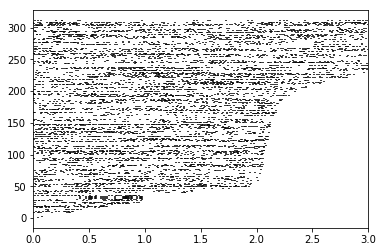

In [666]:
auxSort = np.sort(DRRDtime);
increasing = np.zeros(np.size(auxSort))
for ix in range(np.size(auxSort)):
    aux = np.where(auxSort[ix] == DRRDtime)
    increasing[ix] = aux[0][0]

#raster plot
ax = plt.gca()
ax.set_xlim([0, 3])
for trial in range(np.size(Trials)):
    auxPlot = Spikes[17][increasing[trial]]/30000
    for ts in range(np.size(auxPlot)):
        plt.vlines(auxPlot[ts],trial,trial+.8)
plt.show()
    

In [641]:
#Trials Before change-point
auxBef = np.where(Trials<0)
auxTask = DRRDtime[auxBef[1]]
auxB1 = np.where(auxTask>1)
auxB2 = np.where(auxTask<2.5)
aux = np.intersect1d(auxB1,auxB2)
Bef = auxBef[1][aux]

#Trials After change-point
auxAft = np.where(Trials>0)
auxTask = DRRDtime[auxAft[1]]
auxB1 = np.where(auxTask>1)
auxB2 = np.where(auxTask<2.5)
aux = np.intersect1d(auxB1,auxB2)

#Aft = np.zeros(np.size(aux))
#for idx in range(np.size(aux)):
Aft = auxAft[1][aux]


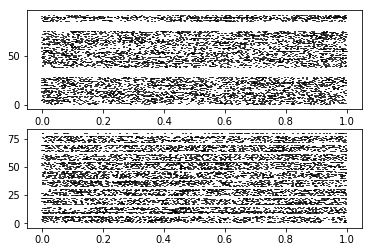

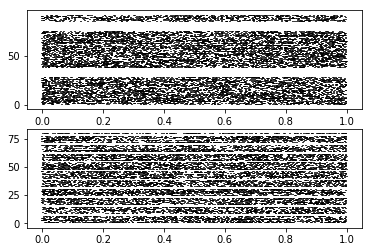

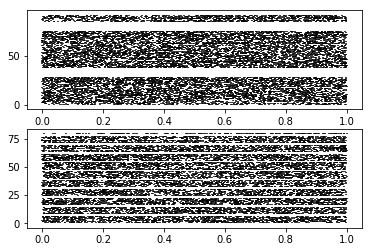

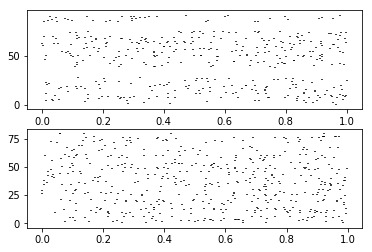

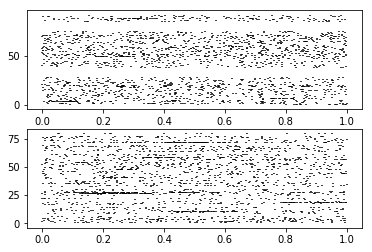

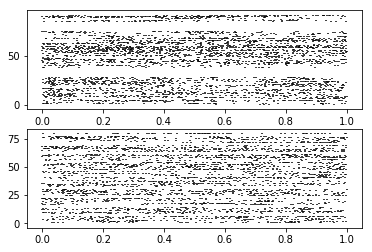

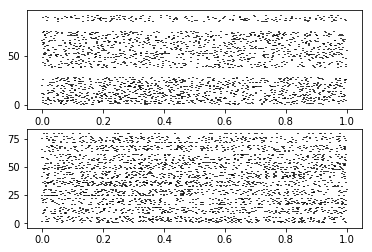

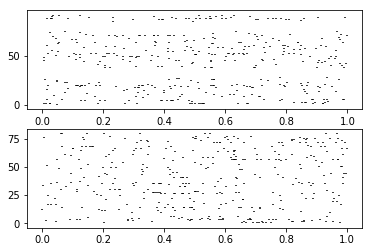

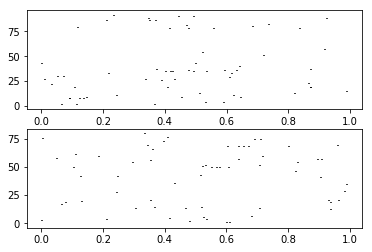

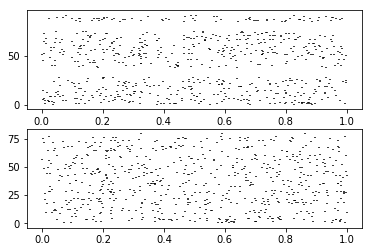

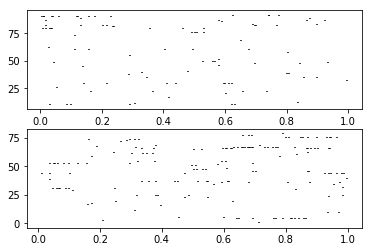

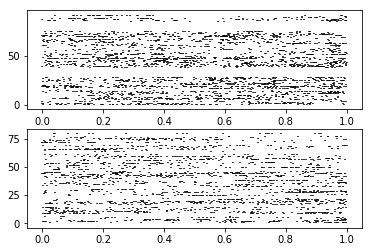

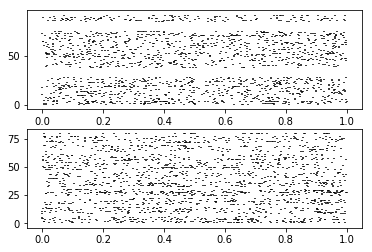

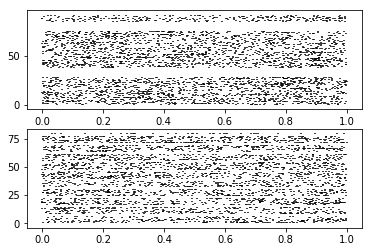

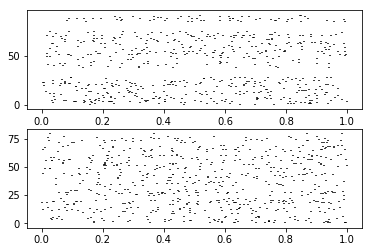

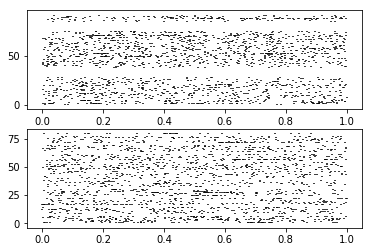

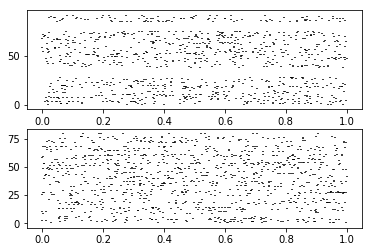

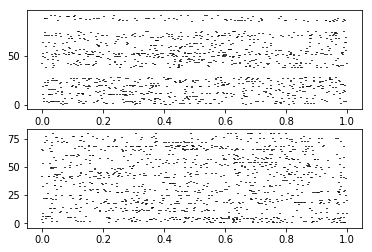

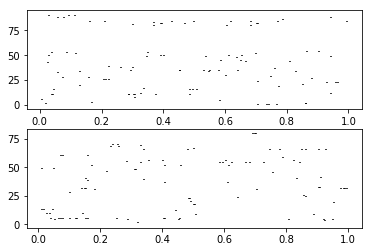

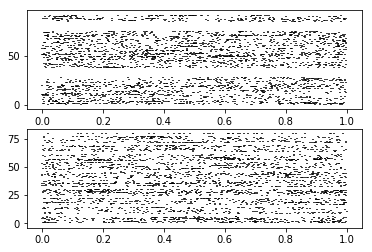

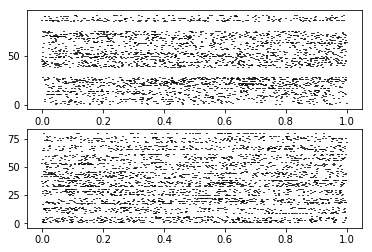

In [667]:
for idx in range(np.size(GoodMUAclus)):
    cls = GoodMUAclus[idx]
    plt.figure(idx)
    #plotting before
    plt.subplot(212)
    ax.set_xlim([0, 3])
    for trial in range(np.size(Bef)):
        auxPlot = Spikes[cls][Bef[trial]]/30000
        auxPlot = auxPlot/DRRDtime[Bef[trial]]
        for ts in range(np.size(auxPlot)):
            plt.vlines(auxPlot[ts],trial,trial+.8)

    #plotting after cp
    plt.subplot(211)
    ax.set_xlim([0, 3])
    for trial in range(np.size(Aft)):
        auxPlot = Spikes[cls][Aft[trial]]/30000
        auxPlot = auxPlot/DRRDtime[Aft[trial]]
        for ts in range(np.size(auxPlot)):
            plt.vlines(auxPlot[ts],trial,trial+.8)

    plt.show()

In [663]:
GoodMUAclus

array([  4,   6,   8,  13,  16,  17,  18,  22,  26,  34,  49, 114, 116,
       117, 143, 192, 229, 230, 252, 261, 267])

In [662]:
NeuronTS['Channels'][:]

array([ 24.,  27.,   0.,  22.,   9.,  28.,  13.,  10.,  20.,   0.,  29.,
         0.,  26.,  22.,   1.,  14.,  20.,  28.,  28.,  31.,  29.])